In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_12DLorenz.recursive_Markovian_PostMeanScore_12DLorenz_Stable_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [45]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


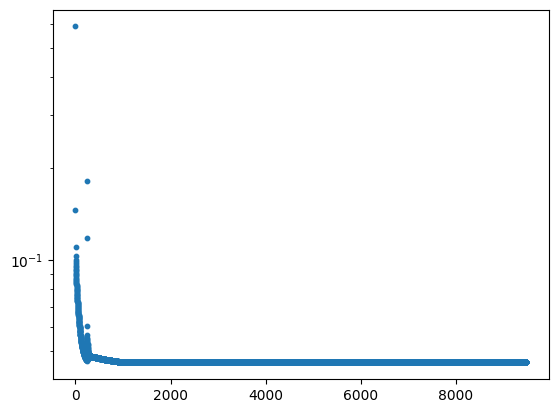

9482

In [46]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

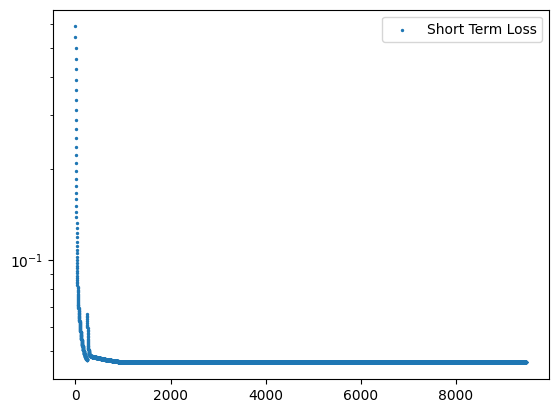

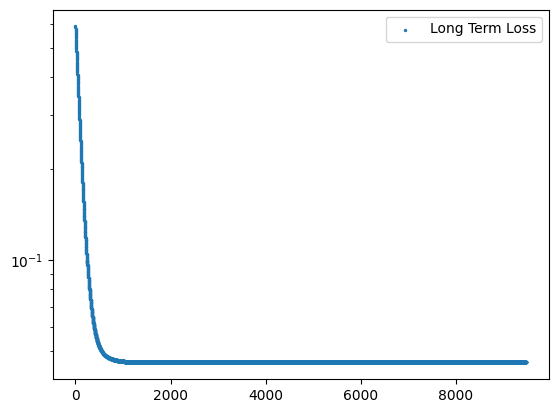

In [47]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

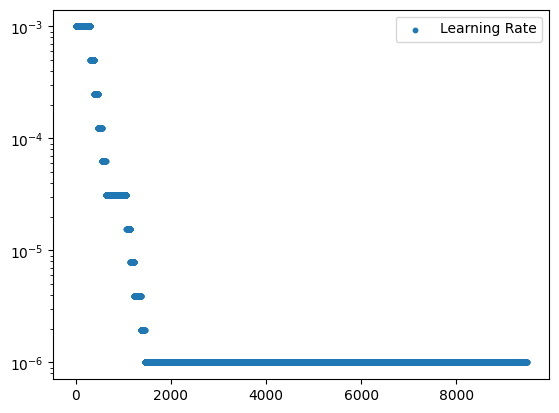

0


In [48]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)

In [49]:
import pandas as pd
root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/12DLnz/"
mses=[]
for file in os.listdir(root_score_dir):
    if "MSE" in file:
        mses.append(pd.read_parquet(root_score_dir+file, engine="fastparquet"))
mses = pd.concat(mses).reset_index(drop=False).rename({"index":"epoch"}, axis=1).sort_values("epoch").reset_index(drop=True)
Nepochs_track = mses["epoch"].values.flatten()

In [50]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])

In [51]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(1000, 20000))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = np.unique([np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs])
track_idx = np.unique([np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs])
red_losses = losses[losses_idx]
print(track_idx.shape, common_epochs.shape)
#track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
track_rmses = mses.iloc[track_idx,:].mse.values.flatten()
print(track_rmses.shape, common_epochs.shape)

(2837,) (2837,)
(2837,) (2837,)


In [52]:
print(common_epochs)

[1002 1005 1008 ... 9474 9477 9480]


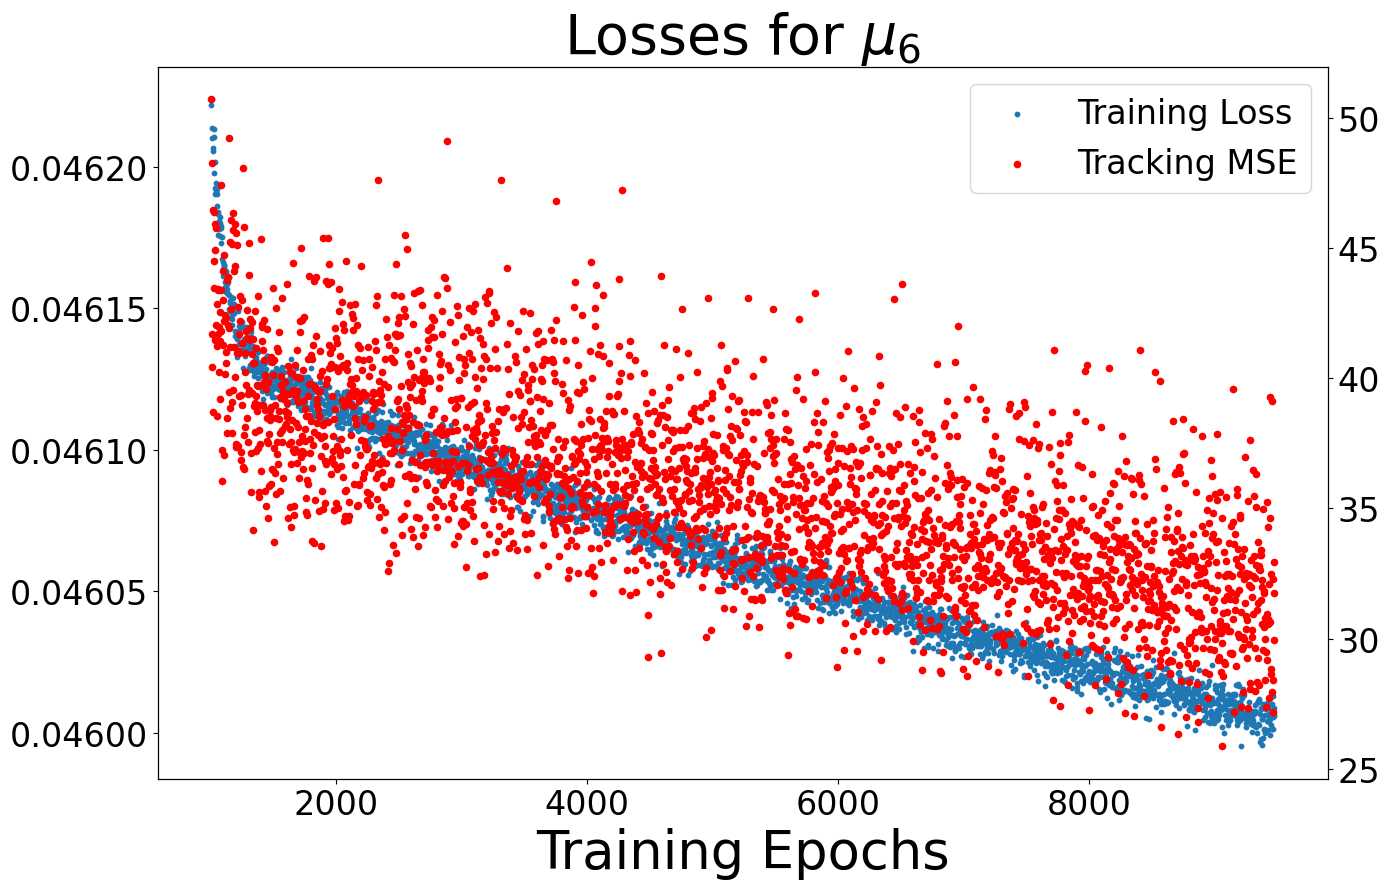

In [53]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
ax.set_title(r"Losses for $\mu_{6}$", fontsize=40)

#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/12DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_{config.forcing_const}FConst_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

In [54]:
print(mses.iloc[np.argmin(mses.mse),:])

epoch    9061.000000
mse        25.865503
Name: 3073, dtype: float64


In [55]:
curr_rmse = np.inf
toSave = False
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 1: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/12DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_DriftTrack_{Nepoch}Nep_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue
# 0.021385787 final time error for 12DLnz at epoch 94 before changing final_tau = init_tau = 1.

NameError: name 'epochs_iter' is not defined

In [ ]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
import torch
scoreModel1 = ConditionalMarkovianTSPostMeanScoreMatching(
        *config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/"
modelname = config.scoreNet_trained_path.replace(rootdir, "")
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel1.load_state_dict(torch.load(rootdir+file))
        print(file)
tau1 =  max(scoreModel1.mlp_state_mapper.hybrid.final_tau,
                          scoreModel1.mlp_state_mapper.hybrid.init_tau * (0.9 ** (94 // 20)))
scoreModel1.eval()
scoreModel2 = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/snapshots/"
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel2.load_state_dict(torch.load(rootdir+file, map_location=torch.device("cpu"))["MODEL_STATE"])
scoreModel2.eval()
tau2 =  max(scoreModel2.mlp_state_mapper.hybrid.final_tau,
                          scoreModel2.mlp_state_mapper.hybrid.init_tau * (0.9 ** (Nepochs_losses[-1] // 20)))
print(tau1, tau2)

In [ ]:
import torch

# Loop through named parameters
for (name_5, param_5), (name_20, param_20) in zip(scoreModel1.named_parameters(), scoreModel2.named_parameters()):
    assert name_5 == name_20  # Sanity check: same parameter names

    # Compute L2 norm of difference
    diff = torch.norm(param_5.data - param_20.data).item()
    print(f"{name_5}: L2 norm difference = {diff:.6f}")


In [ ]:
torch.mean(torch.exp(scoreModel2.mlp_state_mapper.hybrid.log_scale)), torch.mean(torch.sigmoid(scoreModel2.mlp_state_mapper.hybrid.gate_logits / 0.5)), scoreModel2.mlp_state_mapper.hybrid.tau

In [ ]:
Nepoch_good = 170000
Nepoch_bad = 300
good_idx = np.argwhere(common_epochs == Nepoch_good)[0,0]
bad_idx = np.argwhere(common_epochs == Nepoch_bad)[0,0]
good_true = np.load(drift_true_files[good_idx])[0, :, :, :]
good_local = np.load(drift_local_files[good_idx])[0, :,:, :]
bad_true = np.load(drift_true_files[bad_idx])[0, :, :, :]
bad_local = np.load(drift_local_files[bad_idx])[0, :, :,:]
print(bad_local.shape, bad_true.shape)
B, T, D = bad_local.shape

In [ ]:
for dim in range(config.ndims):
    dim_idx = dim + 1
    time_ax = np.linspace(config.t0,config.deltaT*T,T)
    # Print different "true sample paths"
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for _ in range(B):
        axes[0].scatter(time_ax, good_true[_, :, dim]-good_local[_, :, dim], color="red", s=1)
        axes[1].scatter(time_ax, bad_true[_, :, dim]-bad_local[_, :, dim], color="blue", s=1)
    plt.suptitle(f"True vs Score-Based Path Difference for Dimension {dim_idx}\n")
    plt.xlabel("Time")
    plt.ylabel("Path")
    plt.show()
    plt.close()

In [ ]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching

scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters)
training_size = int(sum(p.numel() for p in scoreModel.parameters() if p.requires_grad))

In [ ]:
training_size